In [ ]:
# default_exp analysis

# Tools to analyze the results of Gate simulations

In [ ]:
#hide
from nbdev.showdoc import *

## Dependencies

In [ ]:
#export
import pandas as pd
import uproot as rt
import awkward as ak

from scipy.stats import moyal
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
from scipy.stats import rv_continuous
# import pylandau
from matplotlib.pyplot import hist2d
import matplotlib.colors as mcolors

In [ ]:
#export
def find_max_nonzero(array_hist):
    """returns an upper boundary of the continuos non-zero bins
    
    input a histogram array output from plt.hist
    """
    previous = -1
    preprevious  = -1
    p_b = -1
    pp_b = -1
    for v, b in zip(array_hist[0],array_hist[1]):
        if preprevious != 0 and previous == 0 and v == 0:
            return math.ceil(p_b)
        pp_b = p_b
        p_b = b
        preprevious = previous
        previous = v
    

In [ ]:
show_doc(find_max_nonzero)

<h4 id="find_max_nonzero" class="doc_header"><code>find_max_nonzero</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>find_max_nonzero</code>(**`array_hist`**)

returns an upper boundary of the continuos non-zero bins

input a histogram array output from plt.hist

In [ ]:
#export
def find_range(param):
    """removes a tail in the upper range of the histogram"""
    array_hist = plt.hist(param, bins=100)
    upper_limit = find_max_nonzero(array_hist)
    ret = -1
    for _ in range(10):
        print(f'upper limit: {upper_limit}')
        ret = upper_limit
        array_hist = plt.hist(param[param < upper_limit], bins=100)
        upper_limit = find_max_nonzero(array_hist)
        if ret == upper_limit:
            break
    return ret

In [ ]:
show_doc(find_range)

<h4 id="find_range" class="doc_header"><code>find_range</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>find_range</code>(**`param`**)

removes a tail in the upper range of the histogram

In [ ]:
#export
def get_edep_data(df, sensor=-1):
    """returns an array of energies deposited in each event (keV)"""
    
   
    
    # sum all energy deposited in each event and convert the result to keV
    if sensor == -1:
        edep = df.groupby(['eventID'])['edep'].sum()*1000
    else:
        edep = (df[df['volumeID'] == sensor].groupby(['eventID']))['edep'].sum()*1000
    return edep

In [ ]:
show_doc(get_edep_data)

<h4 id="get_edep_data" class="doc_header"><code>get_edep_data</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>get_edep_data</code>(**`df`**, **`sensor`**=*`-1`*)

returns an array of energies deposited in each event (keV)

In [ ]:
#export
def get_df_subentry2(root_file_name):
    """returns a dataframe that contains only subentry 2 data
    
    This subentry seems to contain all the relevant information"""
    
    df = pd.DataFrame()
    with rt.open(f'{root_file_name}:Hits') as tree:
        df = ak.to_pandas(tree.arrays())
    return df.xs(2, level='subentry')

In [ ]:
show_doc(get_df_subentry2)

<h4 id="get_df_subentry2" class="doc_header"><code>get_df_subentry2</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>get_df_subentry2</code>(**`root_file_name`**)

returns a dataframe that contains only subentry 2 data

This subentry seems to contain all the relevant information

## Example showing energy deposition with 3 sensors

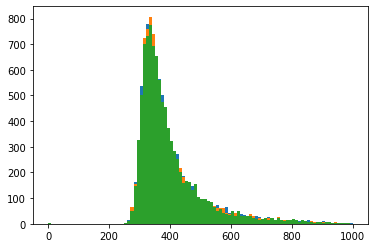

In [ ]:
df2 = get_df_subentry2('results/TrackerHits.root')
edep = get_edep_data(df2, sensor=0)
_ = plt.hist(edep, bins=100, range=(0,1000))
_ = plt.hist(get_edep_data(df2, sensor=1), bins=100, range=(0,1000))
_ = plt.hist(get_edep_data(df2, sensor=2), bins=100, range=(0,1000))

In [ ]:
null_columns = [col for col in df2.columns if df2[col].max() == 0 and df2[col].min() == 0]
df2.drop(columns=null_columns, inplace=True)

In [ ]:
single_value_columns = [col for col in df2.columns if df2[col].max() ==  df2[col].min()]
df2.drop(columns=single_value_columns, inplace=True)
df2.head()

,PDGEncoding,trackID,parentID,trackLocalTime,time,edep,stepLength,trackLength,posX,posY,...,momDirX,momDirY,momDirZ,level1ID,photonID,sourcePosX,sourcePosZ,eventID,volumeID,processName
entry,,,,,,,,,,,,,,,,,,,,,
0,2212,1,0,1.625228e-09,1.625228e-09,0.394049,0.500008,297.753906,-0.089870,-47.75,...,-0.022373,-0.999483,0.023074,0,2,-0.391837,0.482372,1,0,Transportation
1,2212,1,0,1.681641e-09,1.681641e-09,0.435780,0.500258,307.759064,-0.313312,-57.75,...,-0.025283,-0.999469,0.020532,-1,2,-0.391837,0.482372,1,1,Transportation
2,2212,1,0,1.738094e-09,1.738094e-09,0.393910,0.500265,317.764343,-0.565760,-67.75,...,-0.023668,-0.999491,0.021390,-1,2,-0.391837,0.482372,1,2,Transportation
3,2212,1,0,1.621733e-09,1.621733e-09,0.352901,0.500019,297.757568,-0.656078,-47.75,...,-0.002678,-0.999953,-0.009338,0,0,-1.324143,-3.748219,2,0,Transportation
4,2212,1,0,1.677973e-09,1.677973e-09,0.336591,0.500025,307.758057,-0.683030,-57.75,...,-0.000312,-0.999964,-0.008490,-1,0,-1.324143,-3.748219,2,1,Transportation


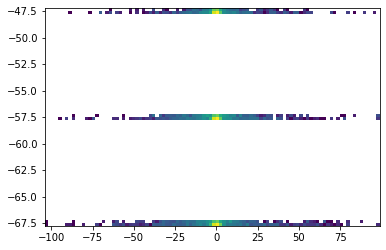

In [ ]:
_ = plt.hist2d(df2['posX']-df2['sourcePosX'], df2['posY'], bins=(100, 80), norm=mcolors.LogNorm())

In [ ]:
df2_sensor0 = df2[df2.volumeID == 0]

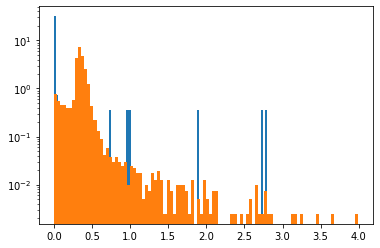

In [ ]:
_= plt.hist((df2_sensor0[(df2_sensor0['processName']=='Transportation') & (df2_sensor0['posY']==-47.25)]).edep,log=True, density=True, bins = 100)
_= plt.hist((df2_sensor0[(df2_sensor0['processName']=='Transportation') & (df2_sensor0['posY']==-47.75)]).edep,log=True, density=True,bins = 100)

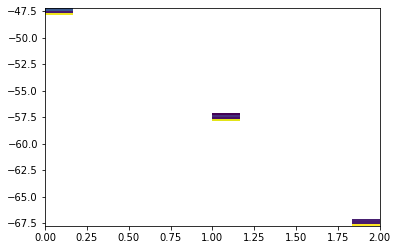

In [ ]:
_= hist2d(df2.volumeID, df2.posY, bins=(12,100), norm=mcolors.LogNorm())

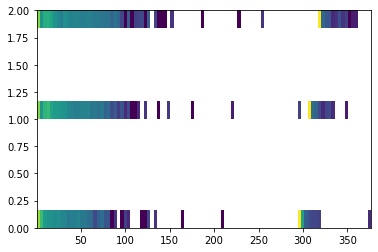

In [ ]:
_ = hist2d(df2.trackLength, df2.volumeID, bins=(100, 12), norm=mcolors.LogNorm())

In [ ]:
import pylandau
class landau_gen(rv_continuous):
    r"""A Landau continuous random variable.
    %(before_notes)s
    Notes
    -----
    The probability density function for `Landau` is:
    
    for a real number :math:`x`.
    %(after_notes)s
    This distribution has utility in high-energy physics and radiation
    detection. It describes the energy loss of a charged relativistic
    particle due to ionization of the medium . 
    """
    
    def _pdf(self, x):
        return pylandau.landau_pdf(np.float64(x))


landau = landau_gen(name="landau")

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_macrotools.ipynb.
Converted 01_analysis.ipynb.
Converted 02_scanners.ipynb.
Converted 20_analysis0.ipynb.
Converted index.ipynb.


In [ ]:
loc,scale =  moyal.fit(edep)
print(loc, scale)

383.5713661065298 215.44240570369095


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


<ipython-input-18-afb1cad1840f>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return pylandau.landau_pdf(np.float64(x))
<ipython-input-18-afb1cad1840f>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return pylandau.landau_pdf(np.float64(x))


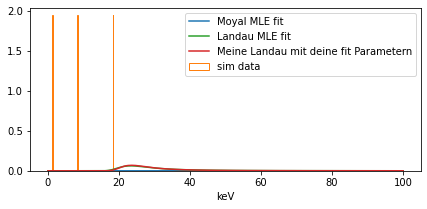

In [ ]:
fig1, ax1 = plt.subplots(figsize=(7, 3))
x = np.linspace(0, 100, 200)
ax1.plot(x, moyal.pdf(x, loc, scale), label = 'Moyal MLE fit')
_ = ax1.hist(edep[edep < 100], bins = 100, histtype='step', density= True, label = 'sim data')
ax1.plot(x, landau.pdf(x, 23.973851592546183, 2.921658875656049), label='Landau MLE fit')
ax1.plot(x, landau.pdf(x, 24.13, 2.629), label='Meine Landau mit deine fit Parametern')
#ax1.scatter(GeV8_data.energy, GeV8_data.counts/4400, label = 'data', marker='o',  c = 'green', alpha = 0.5)
plt.xlabel('keV')
ax1.legend()

In [ ]:
loc,scale =  moyal.fit(edep[edep < 50])
print(loc, scale)

4.607171285784132 3.5588357359363867


In [ ]:
m = np.mean(edep)
em = stats.sem(edep)
tm = stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 1 * np.std(edep) + 2))
etm = stats.tsem(edep, limits=(edep.min(),np.mean(edep) + 1 * np.std(edep) + 2))
print(f'Mean:        {m},       Error on mean: {em}, SNR: {m/em}')
print(f'Trimmed mean {tm}, Error on trimmed mean: {etm}, SNR: {tm/etm}')
#print(stats.mode(np.round(edep, 0)))


Mean:        465.60009765625,       Error on mean: 8.538391660737398, SNR: 54.53018743532778
Trimmed mean 400.85728265348166, Error on trimmed mean: 1.1922625847147752, SNR: 336.21560199289377


In [ ]:
## edep.to_csv('simdata.csv', sep =',', mode='w')